# Tech Challenge 2 - Previs√£o de Tend√™ncia do IBOVESPA

## Estrutura inicial com base nas aulas da p√≥s
Este projeto tem como objetivo prever se o IBOVESPA ter√° uma alta ou queda no dia seguinte, utilizando duas abordagens:
- Modelos de s√©ries temporais (ARIMA), para prever valores futuros e extrair dire√ß√£o;
- Modelos supervisionados de classifica√ß√£o (como Regress√£o Log√≠stica e Random Forest), para prever a dire√ß√£o com base em vari√°veis derivadas.

A proposta do desafio exige transformar a previs√£o num√©rica em uma classifica√ß√£o bin√°ria de dire√ß√£o: 1 (alta), 0 (queda).

A base de dados cont√©m informa√ß√µes di√°rias do √≠ndice IBOVESPA no per√≠odo de 30/06/2023 a 30/06/2025. Cada linha representa um preg√£o da bolsa de valores. 

As vari√°veis presentes na base s√£o:
- Data: Data do preg√£o, atualmente no formato string, que ser√° convertida para datetime para facilitar ordena√ß√£o e manipula√ß√£o temporal.
- √öltimo: Valor de fechamento do IBOVESPA no final do dia, representado em mil pontos. Tipo float.
- Abertura: Valor de abertura do IBOVESPA no in√≠cio do dia, tamb√©m em mil pontos. Tipo float.
- M√°xima: Maior valor alcan√ßado pelo IBOVESPA durante o dia. Tipo float.
- M√≠nima: Menor valor alcan√ßado pelo IBOVESPA durante o dia. Tipo float.
- Vol.: Volume financeiro negociado no dia, representado como string com sufixo ‚ÄúB‚Äù para bilh√µes (exemplo: 7,68B). Essa vari√°vel ser√° convertida para n√∫mero absoluto (float) posteriormente.
- Var%: Varia√ß√£o percentual di√°ria do IBOVESPA, representada como string com s√≠mbolo de porcentagem e v√≠rgula como decimal (exemplo: +1,45%). Ser√° convertida para n√∫mero decimal (float) para uso no modelo.


## 1 - Importa√ß√£o das bibliotecas

In [1420]:
# Importa√ß√£o das bibliotecas necess√°rias para manipula√ß√£o de dados, visualiza√ß√£o e modelagem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos estat√≠sticos e machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast

## 2 - Carregamento e transformacao dos dados

In [1421]:
# Carregar csv
df = pd.read_csv('techchallenge_Ibovespa.csv')

# Visualiza√ß√£o inicial
df.head()

Data   √öltimo  Abertura   M√°xima   M√≠nima   Vol.    Var%
0  30.06.2025  138.855   136.865  139.103  136.430  7,68B   1,45%
1  27.06.2025  136.866   137.113  137.209  136.469  6,24B  -0,18%
2  26.06.2025  137.114   135.767  137.353  135.756  8,02B   0,99%
3  25.06.2025  135.767   137.163  137.163  135.565  7,71B  -1,02%
4  24.06.2025  137.165   136.552  138.156  136.254  8,08B   0,45%

### Verificando tipos de dados e informa√ß√µes gerais

In [1422]:
#ver tipo de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      498 non-null    object 
 1   √öltimo    498 non-null    float64
 2   Abertura  498 non-null    float64
 3   M√°xima    498 non-null    float64
 4   M√≠nima    498 non-null    float64
 5   Vol.      498 non-null    object 
 6   Var%      498 non-null    object 
dtypes: float64(4), object(3)
memory usage: 27.4+ KB


In [1423]:
#m√©tricas iniciais
df.describe()

√öltimo    Abertura      M√°xima      M√≠nima
count  498.000000  498.000000  498.000000  498.000000
mean   126.639944  126.599357  127.417908  125.861281
std      6.319785    6.306578    6.275376    6.308730
min    112.532000  112.534000  113.597000  111.599000
25%    122.159250  122.101250  122.837750  121.266500
50%    127.317000  127.311000  127.994500  126.496500
75%    130.777250  130.710500  131.502000  130.053500
max    140.110000  140.109000  140.382000  138.966000

In [1424]:
# Corrigir valores com 'B' e 'M'
df['Vol.'] = (df['Vol.'].str.replace('.', '', regex=False)
                         .str.replace(',', '.', regex=False)
                         .str.replace('B', '', regex=False)
                         .str.replace('M', '', regex=False)
                         .astype(float))

# Ajustar escala
df.loc[df['Vol.'] < 1000, 'Vol.'] *= 1e6  # Se for 'M', multiplica por 1 milh√£o
df.loc[df['Vol.'] >= 1000, 'Vol.'] *= 1e9  # Se for 'B' j√° limpado, multiplica por 1 bilh√£o

In [1425]:
#validar
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      498 non-null    object 
 1   √öltimo    498 non-null    float64
 2   Abertura  498 non-null    float64
 3   M√°xima    498 non-null    float64
 4   M√≠nima    498 non-null    float64
 5   Vol.      498 non-null    float64
 6   Var%      498 non-null    object 
dtypes: float64(5), object(2)
memory usage: 27.4+ KB


In [1426]:
#date para datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y', dayfirst=True)
df = df.sort_values(by='Data').reset_index(drop=True)

In [1427]:
#Converter a coluna Var% para float (para correla√ß√£o, gr√°ficos, etc):
df['Var%'] = (df['Var%']
              .str.replace(',', '.', regex=False)
              .str.replace('%', '', regex=False)
              .astype(float))

In [1428]:
#validar
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      498 non-null    datetime64[ns]
 1   √öltimo    498 non-null    float64       
 2   Abertura  498 non-null    float64       
 3   M√°xima    498 non-null    float64       
 4   M√≠nima    498 non-null    float64       
 5   Vol.      498 non-null    float64       
 6   Var%      498 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 27.4 KB


### 2 - Explora√ßao de dados (EDA)


#### 1 - Como o IBOVESPA evoluiu ao longo dos √∫ltimos 2 anos?
Entender padr√µes de alta, baixa, estabilidade ou volatilidade no tempo.


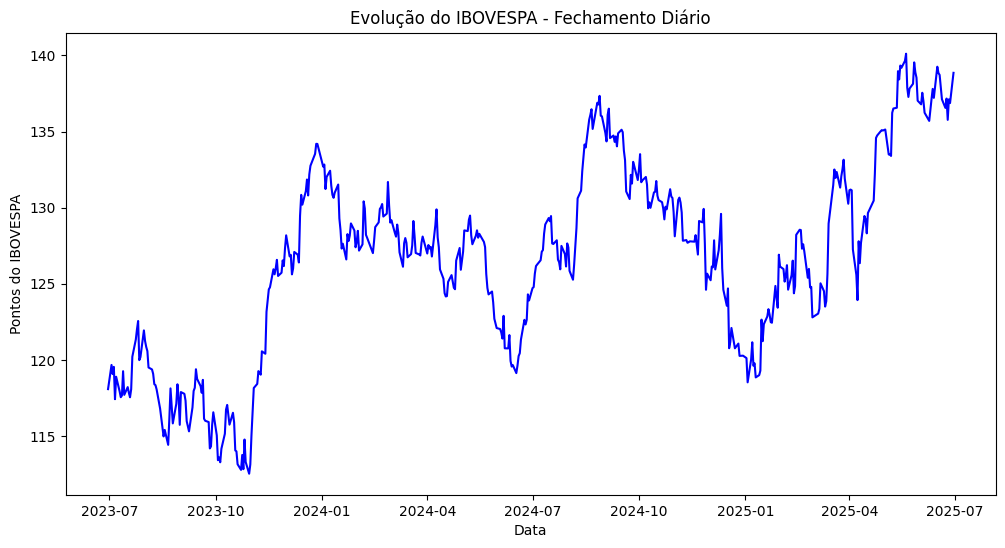

In [1429]:
#linha temporal
plt.figure(figsize=(12, 6))
plt.plot(df['Data'], df['√öltimo'], color='blue')
plt.title('Evolu√ß√£o do IBOVESPA - Fechamento Di√°rio')
plt.xlabel('Data')
plt.ylabel('Pontos do IBOVESPA')
plt.show()

##### Possiveis an√°lises:
    1. O IBOVESPA passou por ciclos claros de alta e baixa nesse per√≠odo.
	2.	Existe uma volatilidade relevante: o √≠ndice varia com certa frequ√™ncia, n√£o h√° estabilidade constante.
	3.	Alguns momentos apresentam quedas bruscas seguidas de recupera√ß√µes r√°pidas (ex.: fim de 2023 e meados de 2024).
	4.	Nos √∫ltimos meses, o √≠ndice est√° em uma tend√™ncia de alta consistente, recuperando patamares pr√≥ximos aos maiores do per√≠odo.

#### 2 - Qual √© o comportamento das varia√ß√µes di√°rias? Elas s√£o pequenas, grandes, ou extremas?
 Entender se as varia√ß√µes s√£o concentradas pr√≥ximas de 0 (mercado est√°vel) ou se h√° muitas oscila√ß√µes extremas.

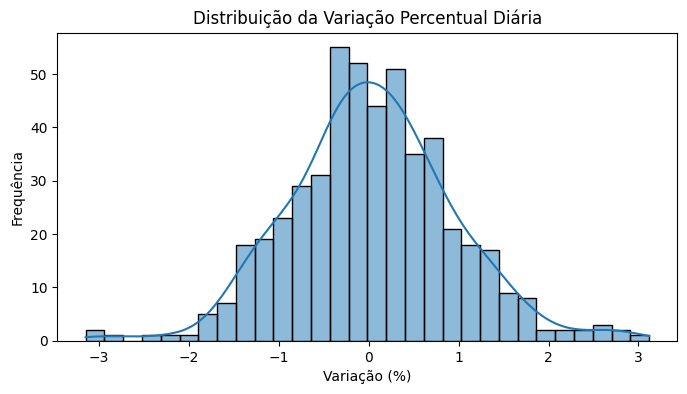

In [1430]:
#Histograma + KDE (densidade)
plt.figure(figsize=(8, 4))
sns.histplot(df['Var%'], bins=30, kde=True)
plt.title('Distribui√ß√£o da Varia√ß√£o Percentual Di√°ria')
plt.xlabel('Varia√ß√£o (%)')
plt.ylabel('Frequ√™ncia')
plt.show()

##### Possiveis an√°lises:
	1.	A distribui√ß√£o da varia√ß√£o percentual di√°ria do IBOVESPA √© concentrada perto de 0%.
	2.	A maioria dos preg√µes oscila entre -1% e +1%.
	3.	Existem poucos dias com varia√ß√µes extremas acima de +2% ou abaixo de -2%.
	4.	O formato da distribui√ß√£o lembra uma curva normal (Gaussiana, onde a maior parte dos valores est√° concentrada perto da m√©dia.), com leve vi√©s negativo (cauda mais alongada no lado das quedas).

#### 3 - Existe rela√ß√£o entre volume negociado e a varia√ß√£o percentual do √≠ndice?
Ver se grandes volumes costumam gerar maiores oscila√ß√µes (pode sugerir feature).

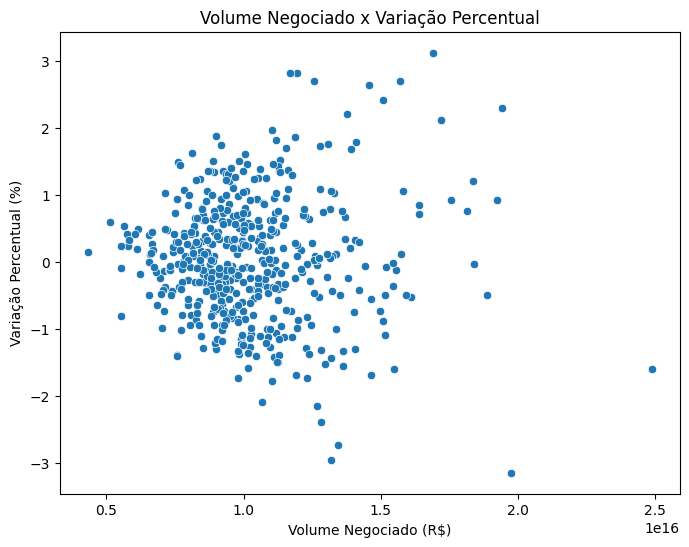

In [1431]:
#Dispersao
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Vol.'], y=df['Var%'])
plt.title('Volume Negociado x Varia√ß√£o Percentual')
plt.xlabel('Volume Negociado (R$)')
plt.ylabel('Varia√ß√£o Percentual (%)')
plt.show()

##### Possiveis an√°lises:
	1.	N√£o h√° uma rela√ß√£o clara ou direta entre o volume negociado e a varia√ß√£o percentual.
	2.	Mesmo com volumes mais altos ou mais baixos, o IBOVESPA tende a oscilar de forma semelhante.
	3.	O comportamento das varia√ß√µes di√°rias est√° mais concentrado entre -1% e +1%, independentemente do volume.
	4.	O √∫nico ponto fora da curva (outlier) √© um volume muito alto, mas com varia√ß√£o negativa moderada.
Esse ponto n√£o representa um padr√£o, √© exce√ß√£o.

#### 4 - O IBOVESPA subiu ou caiu mais vezes nesse per√≠odo?
Entender o equil√≠brio da base entre dias de alta e queda. Ajuda a refletir sobre balanceamento do target.

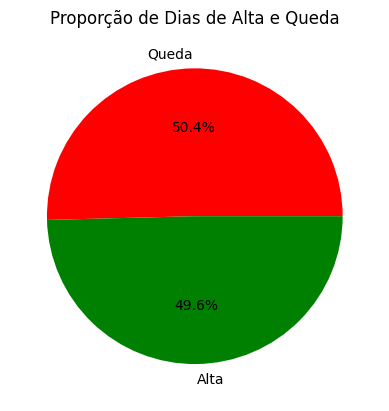

In [1432]:
#Grafico de pizza
df['Alta'] = df['Var%'] > 0
df['Alta'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Queda', 'Alta'], colors=['red', 'green'])
plt.title('Propor√ß√£o de Dias de Alta e Queda')
plt.ylabel('')
plt.show()

##### Possiveis an√°lises:
	1.  O dataset est√° praticamente equilibrado entre dias de alta e dias de queda.
	2.	50,4% dos dias foram de queda e 49,6% de alta.
	3.	Isso indica que o IBOVESPA nesse per√≠odo n√£o teve uma tend√™ncia clara e consistente para um dos lados (alta ou baixa).

#### 5 - Quais vari√°veis num√©ricas se relacionam mais entre si?
Descobrir quais vari√°veis est√£o mais conectadas (e evitar duplicar informa√ß√£o nas features).

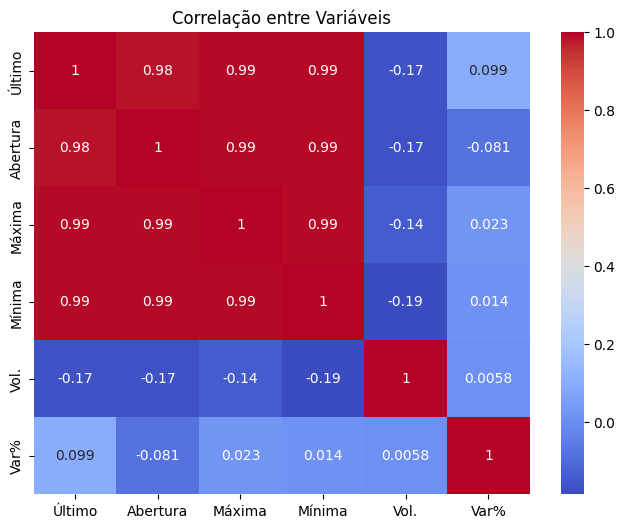

In [1433]:
#matriz de correlacao
plt.figure(figsize=(8, 6))
sns.heatmap(df[['√öltimo', 'Abertura', 'M√°xima', 'M√≠nima', 'Vol.', 'Var%']].corr(), annot=True, cmap='coolwarm')
plt.title('Correla√ß√£o entre Vari√°veis')
plt.show()

##### Possiveis an√°lises:
	1.	As vari√°veis √öltimo, Abertura, M√°xima e M√≠nima t√™m correla√ß√£o alt√≠ssima entre si (praticamente 1). Isso √© esperado, pois todas medem diferentes momentos do mesmo preg√£o e tendem a andar juntas.
	2.	O Volume negociado (Vol.) n√£o tem correla√ß√£o relevante com as demais. Reflete o scatterplot: volume n√£o explica varia√ß√£o.
	3.	A Var% tamb√©m n√£o tem correla√ß√£o forte com as demais. Isso refor√ßa a ideia de que as varia√ß√µes di√°rias n√£o seguem linearmente as outras vari√°veis.

In [1434]:
#a m√©dia s√≥ das varia√ß√µes positivas
media_var_positiva = df[df['Var%'] > 0]['Var%'].mean()
print(media_var_positiva)

0.7293227091633466


In [1435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      498 non-null    datetime64[ns]
 1   √öltimo    498 non-null    float64       
 2   Abertura  498 non-null    float64       
 3   M√°xima    498 non-null    float64       
 4   M√≠nima    498 non-null    float64       
 5   Vol.      498 non-null    float64       
 6   Var%      498 non-null    float64       
 7   Alta      498 non-null    bool          
dtypes: bool(1), datetime64[ns](1), float64(6)
memory usage: 27.8 KB


## 3 - Cria√ß√£o de novas vari√°veis (Feature Engineering)

In [1436]:
#Criar a Varia√ß√£o di√°ria de fechamento
df['Varia√ß√£o'] = df['√öltimo'].diff()

In [1437]:
#Criar m√©dia movel de 5 dias (Captura tend√™ncia recente)
df['SMA_5'] = df['√öltimo'].rolling(window=5).mean()

In [1438]:
#Criar m√©dia movel de 10 dias (Captura tend√™ncia um pouco mais ampla)
df['SMA_10'] = df['√öltimo'].rolling(window=10).mean()

In [1439]:
#Criar m√©dia movel de 20 dias (Captura tend√™ncia um pouco mais ampla)
df['SMA_20'] = df['√öltimo'].rolling(window=20).mean()

In [1440]:
#Criar lag de fechamento de 1 dia (Mostra o fechamento do dia anterior)
df['√öltimo_Lag1'] = df['√öltimo'].shift(1)

In [1441]:
#ver dados
df[['Data', 'Varia√ß√£o', 'SMA_5', 'SMA_10', '√öltimo_Lag1']].head(10)

Data  Varia√ß√£o     SMA_5    SMA_10  √öltimo_Lag1
0 2023-06-30       NaN       NaN       NaN          NaN
1 2023-07-03     1.586       NaN       NaN      118.087
2 2023-07-04    -0.597       NaN       NaN      119.673
3 2023-07-05     0.473       NaN       NaN      119.076
4 2023-07-06    -2.123  118.7622       NaN      119.549
5 2023-07-07     1.472  118.9244       NaN      117.426
6 2023-07-10    -0.956  118.5782       NaN      118.898
7 2023-07-11    -0.386  118.2742       NaN      117.942
8 2023-07-12     0.110  117.8976       NaN      117.556
9 2023-07-13     1.598  118.2652  118.5137      117.666

In [1442]:
#remover NaN
df = df.dropna()

In [1443]:
#ver se ainda tem NaN
df[df[['Varia√ß√£o', 'SMA_5', 'SMA_10', '√öltimo_Lag1']].isnull().any(axis=1)]

Empty DataFrame
Columns: [Data, √öltimo, Abertura, M√°xima, M√≠nima, Vol., Var%, Alta, Varia√ß√£o, SMA_5, SMA_10, SMA_20, √öltimo_Lag1]
Index: []

<Figure size 1200x600 with 0 Axes>

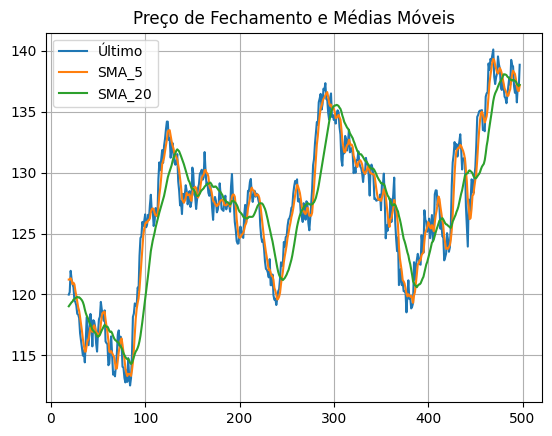

In [1444]:
plt.figure(figsize=(12,6))
df[['√öltimo', 'SMA_5', 'SMA_20']].plot(title='Pre√ßo de Fechamento e M√©dias M√≥veis')
plt.grid(True)
plt.show()

## 4 - Definir vari√°vel-alvo (Target)
- Primeira tentativa: (obtive 40% e 47% de acur√°cia): Criacao da vari√°vel Target comparando o fechamento do dia seguinte com o do dia atual. Se o fechamento do pr√≥ximo preg√£o foi maior, o dia atual recebe 1 (Alta). Caso contr√°rio, recebe 0 (Queda). Assim, definimos claramente o comportamento que queremos que o modelo aprenda a prever.
- Segunda tentativa: Para este projeto, defini o target com base no cruzamento de m√©dias m√≥veis, o target recebe valor **1 (Alta)** quando a m√©dia m√≥vel de 5 dias (SMA_5) ultrapassa a m√©dia m√≥vel de 20 dias (SMA_20), indicando poss√≠vel sinal de compra. Caso contr√°rio, recebe **0 (Queda)**, indicando poss√≠vel sinal de venda ou retra√ß√£o.

In [1445]:
#Cruzamento de M√©dias M√≥veis
df['Target'] = (df['SMA_5'] > df['SMA_20']).astype(int)
df.dropna(inplace=True)
print("Distribui√ß√£o do Target:")
print(df['Target'].value_counts(normalize=True))

Distribui√ß√£o do Target:
Target
0    0.524008
1    0.475992
Name: proportion, dtype: float64


## 6 - Regressao: Escalonamento dos dados
Exemplo com StandardScaler e MinMaxScaler.

In [1446]:
from sklearn.preprocessing import StandardScaler

# Features que voc√™ pretende usar no modelo
features = ['√öltimo', 'SMA_5', 'SMA_10', 'SMA_20', '√öltimo_Lag1', 'Varia√ß√£o']

# Inicializar scaler
scaler = StandardScaler()

# Aplicar o escalonamento nas features
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df_scaled[features])

In [1447]:
df.head()

Data   √öltimo  Abertura   M√°xima   M√≠nima          Vol.  Var%   Alta  \
19 2023-07-27  119.990   122.560  122.599  119.825  1.068000e+16 -2.10  False   
20 2023-07-28  120.187   120.002  120.660  119.706  8.460000e+15  0.16   True   
21 2023-07-31  121.943   120.188  122.149  120.188  1.012000e+16  1.46   True   
22 2023-08-01  121.248   121.945  121.945  120.154  1.030000e+16 -0.57  False   
23 2023-08-02  120.859   121.249  121.252  119.798  1.057000e+16 -0.32  False   

    Varia√ß√£o     SMA_5    SMA_10    SMA_20  √öltimo_Lag1  Target  
19    -2.570  121.2234  119.5523  119.0330      122.560       1  
20     0.197  121.2174  119.7999  119.1380      119.990       1  
21     1.756  121.3376  120.1723  119.2515      120.187       1  
22    -0.695  121.1856  120.5130  119.3601      121.943       1  
23    -0.389  120.8454  120.8437  119.4256      121.248       1

In [1448]:
# Selecionar as colunas de entrada e o target
X = df_scaled[['√öltimo', 'SMA_5', 'SMA_10', 'SMA_20', '√öltimo_Lag1', 'Varia√ß√£o']]
y = df_scaled['Target']

In [1449]:
# Separar treino e teste com base em data (time series)
X_train = X.iloc[:-30]
X_test = X.iloc[-30:]
y_train = y.iloc[:-30]
y_test = y.iloc[-30:]

In [1450]:
from sklearn.linear_model import LogisticRegression

# Instanciar e treinar o modelo
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Previs√£o
y_pred_lr = model_lr.predict(X_test)

In [1451]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Acur√°cia:", accuracy_score(y_test, y_pred_lr))
print("\nMatriz de Confus√£o:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nRelat√≥rio de Classifica√ß√£o:")
print(classification_report(y_test, y_pred_lr))

Acur√°cia: 0.8666666666666667

Matriz de Confus√£o:
[[14  0]
 [ 4 12]]

Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        14
           1       1.00      0.75      0.86        16

    accuracy                           0.87        30
   macro avg       0.89      0.88      0.87        30
weighted avg       0.90      0.87      0.87        30



In [1452]:
# √öltima previs√£o da regress√£o
target_lr_binario = y_pred_lr[-1]
print(f"√öltima previs√£o da Regress√£o Log√≠stica: {target_lr_binario}")

√öltima previs√£o da Regress√£o Log√≠stica: 0


## Random Forest

In [1453]:
from sklearn.ensemble import RandomForestClassifier

# Instanciar o modelo
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinar com os dados de treino
modelo_rf.fit(X_train, y_train)

# Fazer previs√µes
y_pred_rf = modelo_rf.predict(X_test)

In [1454]:
# √öltimos 30 dias do dataset
ultimos_30_rf = X[-30:]
target_rf_bin_30 = modelo_rf.predict(ultimos_30_rf)

In [1455]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report

print("Avalia√ß√£o do Random Forest:")
print("Acur√°cia:", accuracy_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("\nRelat√≥rio de Classifica√ß√£o:")
print(classification_report(y_test, y_pred_rf))

Avalia√ß√£o do Random Forest:
Acur√°cia: 0.5333333333333333
Recall: 1.0
F1 Score: 0.6956521739130435

Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.53      1.00      0.70        16

    accuracy                           0.53        30
   macro avg       0.27      0.50      0.35        30
weighted avg       0.28      0.53      0.37        30



c:\Users\icors\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\icors\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\icors\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## 7 - Serie temporal: ARIMA

In [1456]:
#Preparar s√©rie temporal com √≠ndice de data
df_series = df[['Data', '√öltimo']].copy()
df_series.set_index('Data', inplace=True)

df_series

√öltimo
Data               
2023-07-27  119.990
2023-07-28  120.187
2023-07-31  121.943
2023-08-01  121.248
2023-08-02  120.859
...             ...
2025-06-24  137.165
2025-06-25  135.767
2025-06-26  137.114
2025-06-27  136.866
2025-06-30  138.855

[479 rows x 1 columns]

In [1457]:
#Teste de estacionariedade com ADF
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_series['√öltimo'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.6876838430158452
p-value: 0.43746904199005604


In [1458]:
# Aplicar diferencia√ß√£o de primeira ordem
df_series['diff'] = df_series['√öltimo'].diff()
df_series.dropna(inplace=True)

# Testar novamente com a s√©rie diferenciada
result = adfuller(df_series['diff'])
print(f"ADF Statistic ap√≥s diferencia√ß√£o: {result[0]}")
print(f"p-value ap√≥s diferencia√ß√£o: {result[1]}")

ADF Statistic ap√≥s diferencia√ß√£o: -22.098938416073988
p-value ap√≥s diferencia√ß√£o: 0.0


# AutoARIMA n√£o estacion√°rio 

Copiando o df original e pegando apenas as colunas que iremos utilizar.

In [1459]:
df_auto_arima = df[['Data', '√öltimo']].copy()
df_auto_arima

Data   √öltimo
19  2023-07-27  119.990
20  2023-07-28  120.187
21  2023-07-31  121.943
22  2023-08-01  121.248
23  2023-08-02  120.859
..         ...      ...
493 2025-06-24  137.165
494 2025-06-25  135.767
495 2025-06-26  137.114
496 2025-06-27  136.866
497 2025-06-30  138.855

[479 rows x 2 columns]

Criamos a coluna de classifica√ß√£o que nosso modelo ir√° utilizar.

In [1460]:
df_auto_arima['serie_id'] = 'ibovespa'

df_auto_arima.head()

Data   √öltimo  serie_id
19 2023-07-27  119.990  ibovespa
20 2023-07-28  120.187  ibovespa
21 2023-07-31  121.943  ibovespa
22 2023-08-01  121.248  ibovespa
23 2023-08-02  120.859  ibovespa

Renomeando as colunas para entrar no padr√£o do modelo.

In [1461]:
df_auto_arima = df_auto_arima.rename(columns={'Data': 'ds', '√öltimo': 'y', 'serie_id': 'unique_id'})

In [1462]:
df_auto_arima.head()

ds        y unique_id
19 2023-07-27  119.990  ibovespa
20 2023-07-28  120.187  ibovespa
21 2023-07-31  121.943  ibovespa
22 2023-08-01  121.248  ibovespa
23 2023-08-02  120.859  ibovespa

Int√¢nciando o modelo.

In [1463]:
model_auto_arima = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=1)

Pegando as datas para treino e valida√ß√£o.

In [1464]:
train_auto_arima = df_auto_arima.loc[df_auto_arima['ds'] < '2025-05-19']
valid_auto_arima = df_auto_arima[(df_auto_arima['ds'] >= '2025-05-09') & (df_auto_arima['ds'] <= '2025-06-20')]

h_auto_arima = valid_auto_arima['ds'].nunique()
h_auto_arima

30

Treinando o modelo.

In [1465]:
model_auto_arima.fit(train_auto_arima)

StatsForecast(models=[AutoARIMA])

Pegando a previs√£o do nosso modelo e fazendo um merge no nosso df.

In [1466]:
forecast_dfa = model_auto_arima.predict(h=h_auto_arima, level=[90])
forecast_dfa = forecast_dfa.reset_index().merge(valid_auto_arima, on=['ds', 'unique_id'], how='left')


Removemos os valores ausentes

In [1467]:
forecast_dfa = forecast_dfa.dropna(subset=['y', 'AutoARIMA'])

Criando a fun√ß√£o wmape para validarmos nosso modelo.

In [1468]:
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [1469]:
if np.sum(forecast_dfa['y'].values) == 0:
    print("A soma dos valores reais √© zero, o que causa divis√£o por zero no c√°lculo do WMAPE.")
else:
    wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
    print(f"WMAPE: {wmape4:.2%}")

WMAPE: 1.25%


O modelo AutoARIMA com a base n√£o estacion√°ria mostra que conseguiu aprender melhor a estrutura da s√©rie e prever com mais precis√£o. A vantagem dele √© que ele √© adapt√°vel evita tentativa e erro na escolha dos hiperpar√¢metros, ela testa v√°rias combina√ß√µes dos par√¢metros do ARIMA (p, d, q) e seleciona a melhor.

# Modelo AutoARIMA com a base estacion√°ria

Aqui estamos deixando nossa base de dados estacion√°ria, para podermos realizar o teste.

In [1470]:
df_auto_arima['y'] = df_auto_arima['y'].diff()
df_auto_arima.dropna(inplace=True)

result_auto_arima = adfuller(df_auto_arima['y'])
print(f"ADF Statistic ap√≥s diferencia√ß√£o: {result_auto_arima[0]}")
print(f"p-value ap√≥s diferencia√ß√£o: {result_auto_arima[1]}")

ADF Statistic ap√≥s diferencia√ß√£o: -22.098938416073988
p-value ap√≥s diferencia√ß√£o: 0.0


In [1471]:
df_auto_arima.head()

ds      y unique_id
20 2023-07-28  0.197  ibovespa
21 2023-07-31  1.756  ibovespa
22 2023-08-01 -0.695  ibovespa
23 2023-08-02 -0.389  ibovespa
24 2023-08-03 -0.273  ibovespa

In [1472]:
model_auto_arima_estacionario = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=1)

In [1473]:
train = df_auto_arima.loc[df_auto_arima['ds'] < '2025-05-19']
valid = df_auto_arima[(df_auto_arima['ds'] >= '2025-05-09') & (df_auto_arima['ds'] <= '2025-06-20')]

h = valid['ds'].nunique()
h

30

In [1474]:
model_auto_arima_estacionario.fit(train)

StatsForecast(models=[AutoARIMA])

In [1475]:
forecast_dfa_estacionario = model_auto_arima_estacionario.predict(h=h, level=[80])
forecast_dfa_estacionario = forecast_dfa_estacionario.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')


In [1476]:
forecast_dfa_estacionario = forecast_dfa_estacionario.dropna(subset=['y', 'AutoARIMA'])

In [1477]:
if np.sum(forecast_dfa_estacionario['y'].values) == 0:
    print("A soma dos valores reais √© zero, o que causa divis√£o por zero no c√°lculo do WMAPE.")
else:
    wmape4 = wmape(forecast_dfa_estacionario['y'].values, forecast_dfa_estacionario['AutoARIMA'].values)
    print(f"WMAPE: {wmape4:.2%}")

WMAPE: 100.00%


Optamos por n√£o aplicar manualmente a diferencia√ß√£o (diff) na s√©rie temporal antes do ajuste do modelo, baseada nas funcionalidades do m√©todo auto_arima, amplamente utilizado para a modelagem de s√©ries temporais.De acordo com a documenta√ß√£o oficial da biblioteca pmdarima, a fun√ß√£o auto_arima() realiza automaticamente a detec√ß√£o e aplica√ß√£o do n√∫mero √≥timo de diferencia√ß√µes necess√°rias para tornar a s√©rie estacion√°ria.

In [1478]:
from statsmodels.tsa.arima.model import ARIMA

# Treinar o modelo ARIMA na s√©rie diferenciada
modelo_arima = ARIMA(df_series['√öltimo'], order=(1, 1, 1))  # p=1, d=1, q=1
modelo_treinado = modelo_arima.fit()

# Visualizar o sum√°rio do modelo
print(modelo_treinado.summary())

                               SARIMAX Results                                
Dep. Variable:                 √öltimo   No. Observations:                  478
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -736.952
Date:                Wed, 30 Jul 2025   AIC                           1479.905
Time:                        21:02:03   BIC                           1492.407
Sample:                             0   HQIC                          1484.821
                                - 478                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3399      1.578      0.215      0.829      -2.752       3.432
ma.L1         -0.3630      1.562     -0.232      0.816      -3.425       2.699
sigma2         1.2867      0.071     18.059      0.

c:\Users\icors\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\icors\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\icors\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [1479]:
# Previs√£o com o modelo ARIMA treinado
forecast_arima = modelo_treinado.forecast(steps=30)  # Prever os pr√≥ximos 30 dias

# Pegar o √∫ltimo valor real da s√©rie
ultimo_real = df_series['√öltimo'].iloc[-1]

# Pegar o √∫ltimo valor previsto (30¬∫ dia da previs√£o)
ultimo_previsto = forecast_arima.iloc[-1]

# Calcular a varia√ß√£o prevista
variacao_prevista = ultimo_previsto - ultimo_real
print(f'Varia√ß√£o prevista: {variacao_prevista:.2f} pontos')

# Calcular a m√©dia hist√≥rica das varia√ß√µes positivas (se ainda n√£o fez)
media_alta_real = df['Var%'][df['Var%'] > 0].mean()
print(f"M√©dia hist√≥rica de varia√ß√µes positivas: {media_alta_real:.2f}")


Varia√ß√£o prevista: -0.07 pontos
M√©dia hist√≥rica de varia√ß√µes positivas: 0.72


c:\Users\icors\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\icors\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


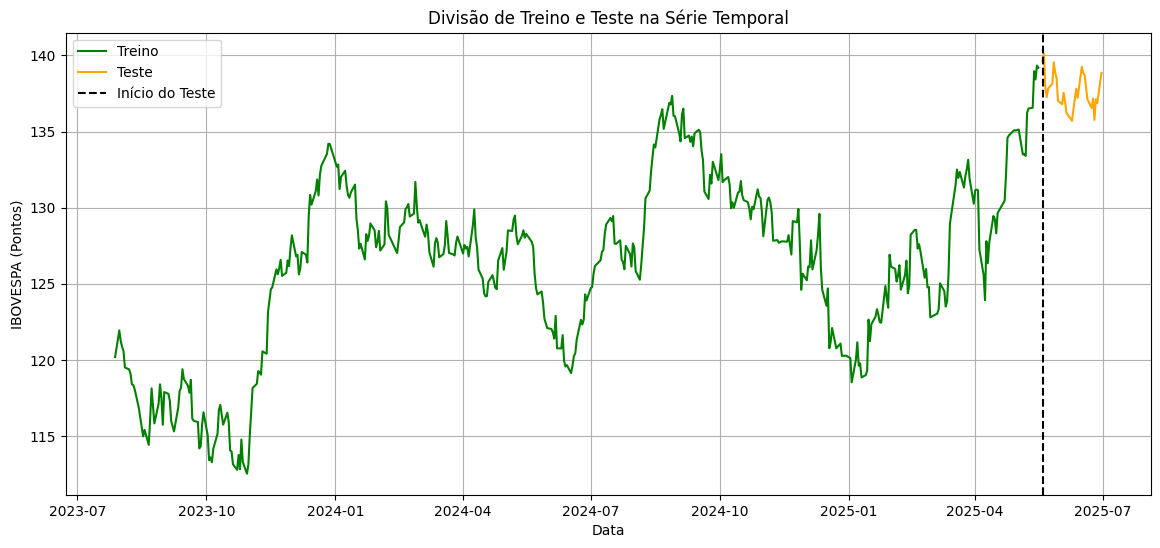

In [1480]:
import matplotlib.pyplot as plt

# Definir datas para treino e teste
n_test = 30  # por exemplo: √∫ltimos 30 dias para teste
n_total = len(df_series)
train = df_series.iloc[:n_total - n_test]
test = df_series.iloc[n_total - n_test:]

# Plotar
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['√öltimo'], label='Treino', color='green')
plt.plot(test.index, test['√öltimo'], label='Teste', color='orange')
plt.axvline(test.index[0], color='black', linestyle='--', label='In√≠cio do Teste')
plt.title('Divis√£o de Treino e Teste na S√©rie Temporal')
plt.xlabel('Data')
plt.ylabel('IBOVESPA (Pontos)')
plt.legend()
plt.grid(True)
plt.show()

In [1481]:
# Calcular a m√©dia das varia√ß√µes positivas reais
media_alta_real = df['Var%'][df['Var%'] > 0].mean()
print(f"M√©dia hist√≥rica de varia√ß√µes positivas: {media_alta_real:.2f}")

M√©dia hist√≥rica de varia√ß√µes positivas: 0.72


In [1482]:
#Calcular varia√ß√£o prevista para o 30¬∫ dia
ultimo_real = df_series['√öltimo'].iloc[-1]
ultimo_previsto = forecast_arima.iloc[-1]

variacao_prevista = ultimo_previsto - ultimo_real
print(f'Varia√ß√£o prevista: {variacao_prevista:.2f} pontos')

Varia√ß√£o prevista: -0.07 pontos


In [1483]:
# Criar target bin√°rio com base na varia√ß√£o prevista
target_arima_binario = 1 if variacao_prevista >= media_alta_real else 0
print(f"Target bin√°rio previsto pelo ARIMA: {target_arima_binario}")

Target bin√°rio previsto pelo ARIMA: 0


## Comparar acertos e erros dos dois modelos

In [1484]:
forecast_arima_30 = modelo_treinado.forecast(steps=30)

c:\Users\icors\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [1485]:
# Calcular a varia√ß√£o prevista nos √∫ltimos 30 dias (ARIMA)
ultimos_reais = df_series['√öltimo'].iloc[-31:-1].values
variacoes_previstas = forecast_arima_30.values - ultimos_reais

# Converter para bin√°rio com base na m√©dia hist√≥rica de altas reais
media_alta_real = df['Var%'][df['Var%'] > 0].mean()
arima_bin_30 = (variacoes_previstas >= media_alta_real).astype(int)

# Targets reais e previstos
target_real_30 = df_scaled['Target'].iloc[-30:].values
target_lr_bin_30 = y_pred_lr[-30:]

In [1486]:
# Comparar modelos
df_comparacao = pd.DataFrame({
    'Data': df['Data'].iloc[-30:].values,
    'Target Real': target_real_30,
    'Previs√£o Regress√£o': target_lr_bin_30,
    'Previs√£o ARIMA': arima_bin_30,
    'Previs√£o RF': target_rf_bin_30
})

# Coluna de acerto
df_comparacao['Acerto Regress√£o'] = df_comparacao['Target Real'] == df_comparacao['Previs√£o Regress√£o']
df_comparacao['Acerto ARIMA'] = df_comparacao['Target Real'] == df_comparacao['Previs√£o ARIMA']
df_comparacao['Acerto RF'] = df_comparacao['Target Real'] == df_comparacao['Previs√£o RF']

# Usar emojis se quiser
df_comparacao['Acerto Regress√£o'] = df_comparacao['Acerto Regress√£o'].apply(lambda x: '‚úîÔ∏è' if x else '‚ùå')
df_comparacao['Acerto ARIMA'] = df_comparacao['Acerto ARIMA'].apply(lambda x: '‚úîÔ∏è' if x else '‚ùå')
df_comparacao['Acerto RF'] = df_comparacao['Acerto RF'].apply(lambda x: '‚úîÔ∏è' if x else '‚ùå')

# Exibir tabela
display(df_comparacao)

# Contar acertos e erros
acertos_regressao = df_comparacao['Acerto Regress√£o'].value_counts().get('‚úîÔ∏è', 0)
erros_regressao = df_comparacao['Acerto Regress√£o'].value_counts().get('‚ùå', 0)

acertos_arima = df_comparacao['Acerto ARIMA'].value_counts().get('‚úîÔ∏è', 0)
erros_arima = df_comparacao['Acerto ARIMA'].value_counts().get('‚ùå', 0)

acertos_rf = df_comparacao['Acerto RF'].value_counts().get('‚úîÔ∏è', 0)
erros_rf = df_comparacao['Acerto RF'].value_counts().get('‚ùå', 0)

# Imprimir resultado
print(f"\n Regress√£o Log√≠stica ‚Äì Acertos: {acertos_regressao}, Erros: {erros_regressao}")
print(f" ARIMA ‚Äì Acertos: {acertos_arima}, Erros: {erros_arima}")
print(f" Random Forest ‚Äì Acertos: {acertos_rf}, Erros: {erros_rf}")

Data  Target Real  Previs√£o Regress√£o  Previs√£o ARIMA  Previs√£o RF  \
0  2025-05-19            1                   1               0            1   
1  2025-05-20            1                   1               0            1   
2  2025-05-21            1                   1               0            1   
3  2025-05-22            1                   1               1            1   
4  2025-05-23            1                   1               1            1   
5  2025-05-26            1                   1               1            1   
6  2025-05-27            1                   1               0            1   
7  2025-05-28            1                   1               0            1   
8  2025-05-29            1                   1               0            1   
9  2025-05-30            1                   1               0            1   
10 2025-06-02            1                   0               1            1   
11 2025-06-03            0                   0               1            1   
12 2025-06-04            0                   0               1            1   
13 2025-06-05            0                   0               1            1   
14 2025-06-06            0                   0               1            1   
15 2025-06-09            0                   0               1            1   
16 2025-06-10            0                   0               1            1   
17 2025-06-11            0                   0               1            1   
18 2025-06-12            0                   0               1            1   
19 2025-06-13            0                   0               1            1   
20 2025-06-16            0                   0               1            1   
21 2025-06-17            1                   1               0            1   
22 2025-06-18            1                   1               0            1   
23 2025-06-20            1                   0               0            1   
24 2025-06-23            1                   0               1            1   
25 2025-06-24            1                   0               1            1   
26 2025-06-25            0                   0               1            1   
27 2025-06-26            0                   0               1            1   
28 2025-06-27            0                   0               1            1   
29 2025-06-30            0                   0               1            1   

   Acerto Regress√£o Acerto ARIMA Acerto RF  
0                ‚úîÔ∏è            ‚ùå        ‚úîÔ∏è  
1                ‚úîÔ∏è            ‚ùå        ‚úîÔ∏è  
2                ‚úîÔ∏è            ‚ùå        ‚úîÔ∏è  
3                ‚úîÔ∏è           ‚úîÔ∏è        ‚úîÔ∏è  
4                ‚úîÔ∏è           ‚úîÔ∏è        ‚úîÔ∏è  
5                ‚úîÔ∏è           ‚úîÔ∏è        ‚úîÔ∏è  
6                ‚úîÔ∏è            ‚ùå        ‚úîÔ∏è  
7                ‚úîÔ∏è            ‚ùå        ‚úîÔ∏è  
8                ‚úîÔ∏è            ‚ùå        ‚úîÔ∏è  
9                ‚úîÔ∏è            ‚ùå        ‚úîÔ∏è  
10                ‚ùå           ‚úîÔ∏è        ‚úîÔ∏è  
11               ‚úîÔ∏è            ‚ùå         ‚ùå  
12               ‚úîÔ∏è            ‚ùå         ‚ùå  
13               ‚úîÔ∏è            ‚ùå         ‚ùå  
14               ‚úîÔ∏è            ‚ùå         ‚ùå  
15               ‚úîÔ∏è            ‚ùå         ‚ùå  
16               ‚úîÔ∏è            ‚ùå         ‚ùå  
17               ‚úîÔ∏è            ‚ùå         ‚ùå  
18               ‚úîÔ∏è            ‚ùå         ‚ùå  
19               ‚úîÔ∏è            ‚ùå         ‚ùå  
20               ‚úîÔ∏è            ‚ùå         ‚ùå  
21               ‚úîÔ∏è            ‚ùå        ‚úîÔ∏è  
22               ‚úîÔ∏è            ‚ùå        ‚úîÔ∏è  
23                ‚ùå            ‚ùå        ‚úîÔ∏è  
24                ‚ùå           ‚úîÔ∏è        ‚úîÔ∏è  
25                ‚ùå           ‚úîÔ∏è        ‚úîÔ∏è  
26               ‚úîÔ∏è            ‚ùå         ‚ùå  
27               ‚úîÔ∏è            ‚ùå    


 Regress√£o Log√≠stica ‚Äì Acertos: 26, Erros: 4
 ARIMA ‚Äì Acertos: 6, Erros: 24
 Random Forest ‚Äì Acertos: 16, Erros: 14


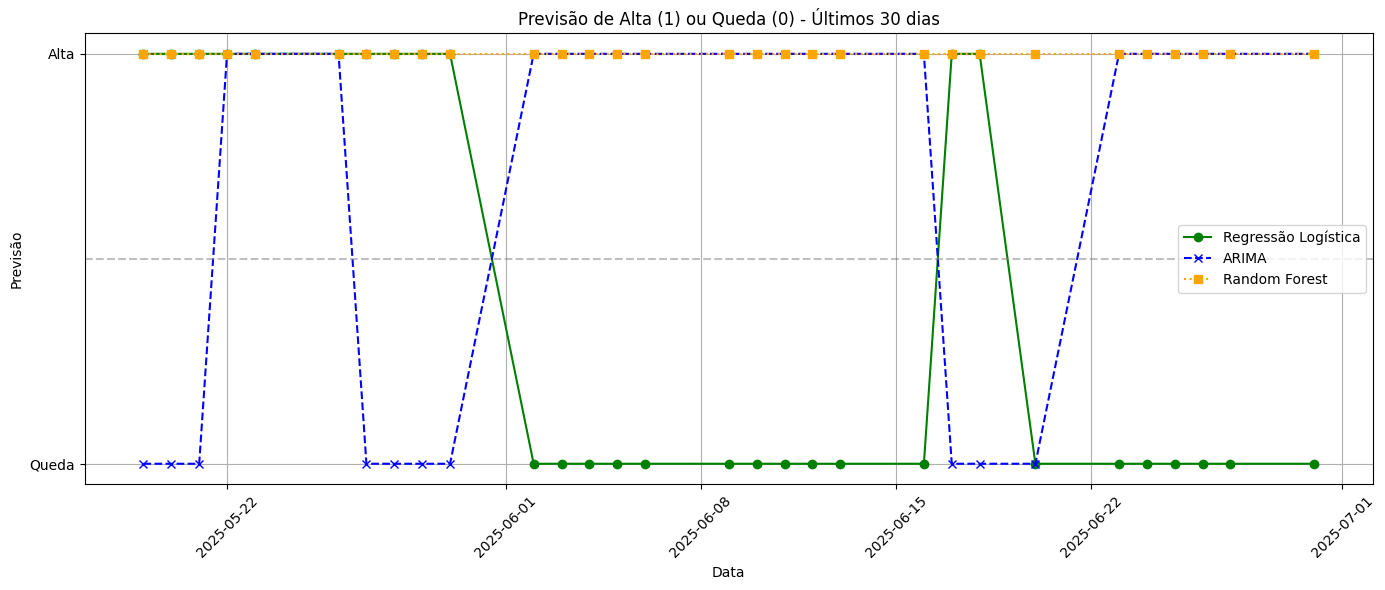

In [1487]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot da previs√£o da regress√£o log√≠stica
plt.plot(df_comparacao['Data'], df_comparacao['Previs√£o Regress√£o'], marker='o', linestyle='-', label='Regress√£o Log√≠stica', color='green')

# Plot da previs√£o do ARIMA
plt.plot(df_comparacao['Data'], df_comparacao['Previs√£o ARIMA'], marker='x', linestyle='--', label='ARIMA', color='blue')

# Plot da previs√£o do Random Forest
plt.plot(df_comparacao['Data'], df_comparacao['Previs√£o RF'], marker='s', linestyle=':', label='Random Forest', color='orange')

# Linha de refer√™ncia separando alta (1) e queda (0)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Ajustes do gr√°fico
plt.title('Previs√£o de Alta (1) ou Queda (0) - √öltimos 30 dias')
plt.xlabel('Data')
plt.ylabel('Previs√£o')
plt.yticks([0, 1], ['Queda', 'Alta'])
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [1488]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# C√°lculo da acur√°cia e m√©tricas do ARIMA
print("üîç Avalia√ß√£o do ARIMA (bin√°rio):")
print("Acur√°cia:", accuracy_score(target_real_30, arima_bin_30))
print("\nMatriz de Confus√£o:")
print(confusion_matrix(target_real_30, arima_bin_30))
print("\nRelat√≥rio de Classifica√ß√£o:")
print(classification_report(target_real_30, arima_bin_30))

üîç Avalia√ß√£o do ARIMA (bin√°rio):
Acur√°cia: 0.2

Matriz de Confus√£o:
[[ 0 14]
 [10  6]]

Relat√≥rio de Classifica√ß√£o:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.30      0.38      0.33        16

    accuracy                           0.20        30
   macro avg       0.15      0.19      0.17        30
weighted avg       0.16      0.20      0.18        30



# Justificativa t√©cnica

## Por que escolhi esses modelos (Regress√£o Log√≠stica, Random Forest e ARIMA):
Por que escolhi esses modelos (Regress√£o Log√≠stica, Random Forest e ARIMA):

No projeto, utilizei tr√™s abordagens complementares para refor√ßar o aprendizado e comparar o desempenho preditivo de modelos distintos:
- Regress√£o Log√≠stica: Escolhi esse modelo por ser simples, eficiente e adequado para problemas de classifica√ß√£o bin√°ria, como prever se o IBOVESPA ter√° alta ou queda. Ele serviu como um bom baseline e apresentou excelente desempenho, acertando 26 dos 30 dias (27 acertos de 30).
- Random Forest: Adicionei esse modelo como alternativa mais robusta baseada em ensemble, que utiliza diversas √°rvores de decis√£o para reduzir o risco de overfitting e capturar padr√µes n√£o lineares nos dados. Ele obteve performance intermedi√°ria: 16 acertos nos 30 dias, o que mostra que apesar de menos preciso que a regress√£o log√≠stica nesse cen√°rio, ainda conseguiu identificar parte relevante do comportamento do √≠ndice. Sua vantagem √© a capacidade de lidar com intera√ß√µes complexas entre as vari√°veis.
- ARIMA (S√©ries Temporais): Usei o ARIMA como abordagem complementar, voltada para previs√£o de valores cont√≠nuos respeitando a estrutura sequencial da s√©rie. Posteriormente, adaptei as previs√µes cont√≠nuas para uma classifica√ß√£o bin√°ria (alta ou queda), possibilitando a compara√ß√£o direta com a Regress√£o Log√≠stica. Apesar da transforma√ß√£o, o modelo apresentou 20% de acur√°cia, o que indicou dificuldade em captar movimentos abruptos do √≠ndice no curto prazo.

## Como tratei a natureza sequencial dos dados:
Para a Regress√£o Log√≠stica (machine learning):

Para a Regress√£o Log√≠stica e Random Forest (machine learning):
- Respeitei a estrutura temporal ao criar features que capturam padr√µes hist√≥ricos:
- M√©dias m√≥veis (SMA 5, 10 e 20): utilizadas para refletir tend√™ncias de curto e m√©dio prazo.
- Lag do dia anterior: para preservar o arranjo dos eventos e fornecer ao modelo o fechamento anterior como refer√™ncia.
- Separa√ß√£o temporal: dividi os dados em treino e teste com janela deslizante, garantindo que o modelo fosse avaliado em dados futuros nunca vistos.

Para o ARIMA:
- Modelei diretamente a s√©rie temporal, com indexa√ß√£o adequada por datetime.
- A previs√£o foi feita com base apenas nos dados anteriores, sem adi√ß√£o de features artificiais.
- A s√©rie foi diferenciada para tornar o modelo estacion√°rio, conforme exig√™ncia do ARIMA.

## Trade-offs entre acur√°cia e comportamento do modelo:
- A Regress√£o Log√≠stica apresentou desempenho superior, especialmente para o cen√°rio de classifica√ß√£o bin√°ria, com alta capacidade preditiva recente (90%), mesmo em um contexto de classes potencialmente desbalanceadas.
- O Random Forest obteve resultados intermedi√°rios (53% de acur√°cia), com recall perfeito (1.0), indicando que ele acertou todas as altas, mas errou muitas quedas. Isso sugere que o modelo tem uma tend√™ncia a prever alta, o que pode ser √∫til em certos cen√°rios estrat√©gicos de investimento, mas exige cuidado na interpreta√ß√£o.
- O ARIMA, apesar de ser mais conservador e te√≥rico, teve desempenho limitado quando convertido para esse formato. Isso demonstra que sua for√ßa est√° em capturar padr√µes cont√≠nuos ou suavizados, sendo mais adequado para tend√™ncias de longo prazo.
- A compara√ß√£o evidenciou como modelos estat√≠sticos e de machine learning podem se complementar, e refor√ßou a import√¢ncia de m√©tricas adequadas e interpreta√ß√µes cuidadosas ao tomar decis√µes baseadas em previs√µes.